In [1]:
# Importing required libraries
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute, IBMQ
from qiskit.providers.jobstatus import JobStatus

import time
from math import *
import random
import operator

In [2]:
main_string = 'KTIIYTLM'
search_string = 'YTL'

N = len(main_string)
M = len(search_string)
s = ceil(log2(N - M))
total_qubits = s * M + 1
ancilla_bit_id = s * M

print('Main string length (N): ', N)
print('Sub string length (M): ', M)
print('Number of registers for each character (s): ', s)
print('Total Qubits: ', total_qubits)

Main string length (N):  8
Sub string length (M):  3
Number of registers for each character (s):  3
Total Qubits:  10


In [3]:
# Quantum Configuration
qr = QuantumRegister(total_qubits, "q")
cr = ClassicalRegister(s, "c")
qc = QuantumCircuit(qr, cr)

In [4]:
# Initialize the qubits to uniform superposition
for i in range(0, s):
    qc.h(qr[i])
    
for i in range(0, M-1):
    # Add CNOT gates to copy positional encoding to the next set
    for j in range(0, s):
        qc.cx(qr[i * s + j], qr[(i + 1) * s + j])
    qc.barrier()
    # Increment the positional encoding
    for j in range(0, s):
        inverted_control_bit = (i + 1) * s - (j + 1)
        # Flip the first control bit
        qc.x(qr[inverted_control_bit])
        control_bits = list(range(inverted_control_bit, (i + 1) * s))
        # Apply multi-controlled CX
        for target_bits in range((i + 2) * s - 1, inverted_control_bit + s - 1, -1):
            qc.mcx(control_bits, target_bits, ancilla_qubits = [target_bits + 1])
        # Unflip the first control bit
        qc.x(qr[inverted_control_bit])
        qc.barrier()

In [5]:
# The Oracle Function
def oracle_function(search_base, start_index):
    target_bit = (start_index + 1) * s - 1
    for i, base in enumerate(main_string):
        if base == search_base:
            # Binary representation of 'i' as a string
            binary_i = format(i, '0'+str(s)+'b')

            # Convert Binary representation using Phase gate
            for j in range(0, s):
                if binary_i[j] == '0':
                    qc.x(qr[start_index * s + j])
                    
            qc.barrier()
            qc.h(qr[target_bit])

            control_bits = list(range(start_index * s, target_bit))
            # Apply multi controlled CX
            qc.mct(control_bits, target_bit, ancilla_qubits = [target_bit + 1])
            
            qc.h(qr[target_bit])
            qc.barrier()

            # Uncomputation of Phase gate
            for j in range(0, s):
                if binary_i[j] == '0':
                    qc.x(qr[start_index * s + j])
                    
    qc.barrier()
    return

In [6]:
# Grover's amplitude amplification function
def amplitude_amplification():
    target_bit = ancilla_bit_id - 1

    for i in range(0, ancilla_bit_id):
        qc.h(qr[i])
        qc.x(qr[i])
    
    qc.barrier()
    qc.h(qr[ancilla_bit_id - 1])
 
    control_bits = list(range(0, target_bit))
    qc.mcx(control_bits, target_bit, ancilla_qubits = [ancilla_bit_id])
    
    qc.h(qr[ancilla_bit_id - 1])
    qc.barrier()

    for i in range(0, ancilla_bit_id):
        qc.x(qr[i])
        qc.h(qr[i])
        
    qc.barrier()
    return

In [7]:
# Applying Grover's Iterations
grovers_iterations = int((sqrt(N/M)))
for _ in range(0, grovers_iterations):
    for i in range(0, M):
        oracle_function(search_string[i], i)
        amplitude_amplification()

for i in range(0, s):
    qc.measure(qr[i], cr[i])

In [8]:
#qc.draw('mpl')

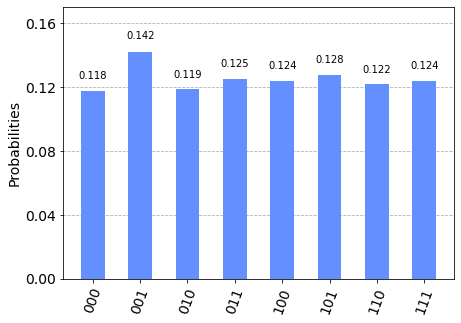

In [9]:
backend = Aer.get_backend('qasm_simulator')
max_shots = 8192
job = execute(qc, backend, shots = max_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [10]:
# provider = IBMQ.load_account()
# provider.backends()

In [11]:
#backend = provider.get_backend('ibmq_athens')
#max_shots = 8192
#job = execute(qc, backend, shots = max_shots)
#counts = job.result().get_counts()
#plot_histogram(counts)